<a href="https://colab.research.google.com/github/VeronikaShe/ML-study_HW_TimeSeries/blob/main/%D0%94%D0%97_MA_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для Python 3.10 следующий набор версий библиотек рабочий и не падает с ошибками при выполнении данного ноутбука:

<ul>
    <li>pandas==2.0.3</li>
    <li>numpy==1.24.4</li>
    <li>statsmodels==0.14.4</li>
    <li>matplotlib==3.10.0</li>
    <li>scipy==1.10.1</li>
</ul>


# Элементарные методы анализа временных рядов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [77]:
female_births = pd.read_csv("https://raw.githubusercontent.com/VeronikaShe/ML-study_HW_TimeSeries/refs/heads/main/daily-total-female-births-in-cal.csv")

In [78]:
all_series = {
    "Daily total female births in California": female_births["Count"]
}

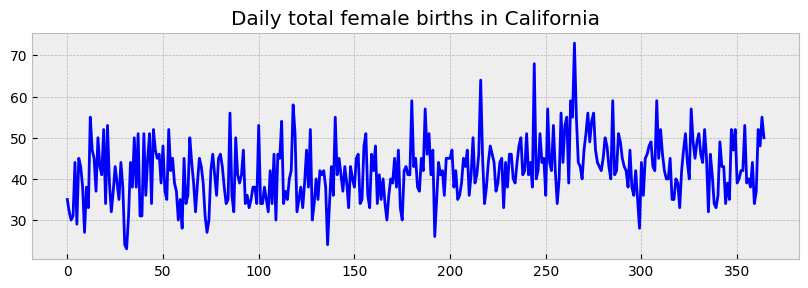

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

# Скользящее среднее MA на нестационарном

Чем больше размер "окна" скользящего среднего $n$ тем более сглаженным получается результат. По нескольким скользящим средним можно увидеть периоды резкого роста и резкого спада.

Характерная особенность обычного скользящего среднего - повышенная чувствительность к выбросам данных

В случае сильно зашумленных данных скользящее среднее помогает определить тренд

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо просто предсказания вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

В данном случае $\hat{y}_{t}$ называется скользящей средней

In [6]:
series = all_series["Daily total female births in California"]

In [7]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

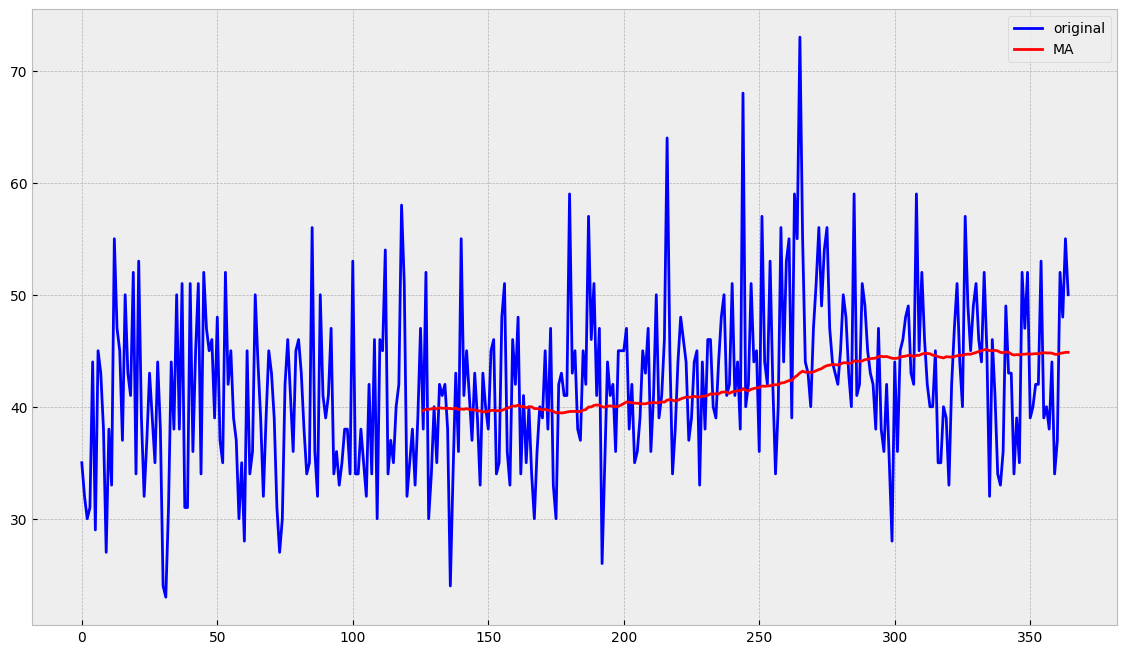

In [16]:

ma = moving_average(all_series["Daily total female births in California"], 127)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Daily total female births in California"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

Такая вариация moving average позволяет учитывать временной контекст. Чем раньше было событие - тем меньше оно влияет на прогнозируемое событие


In [9]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [10]:
import scipy
scipy.__version__

'1.16.3'

In [23]:
train, test, val = series[:300], series[300:330], series[330:]

In [12]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        next_val = new_series[-N:].mean()
        next_val_series = pd.Series([next_val])
        new_series = pd.concat([new_series, next_val_series], ignore_index=True)
    return new_series

In [13]:
def mse(X):
    n = int(X[0])
    result = predict(train, n, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [14]:
opt = minimize(mse, x0=[16], method='Powell', bounds=((1, len(train)),))

In [15]:
n_opt = opt.x
print(opt)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 35.20596991749929
       x: [ 1.272e+02]
     nit: 2
   direc: [[ 6.099e-03]]
    nfev: 80


# Экспоненциальное сглаживание EMA на нестационарном

Продолжаем развивать идею с историей. Мы хотим учитывать на самом деле учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное срденее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд.

In [17]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

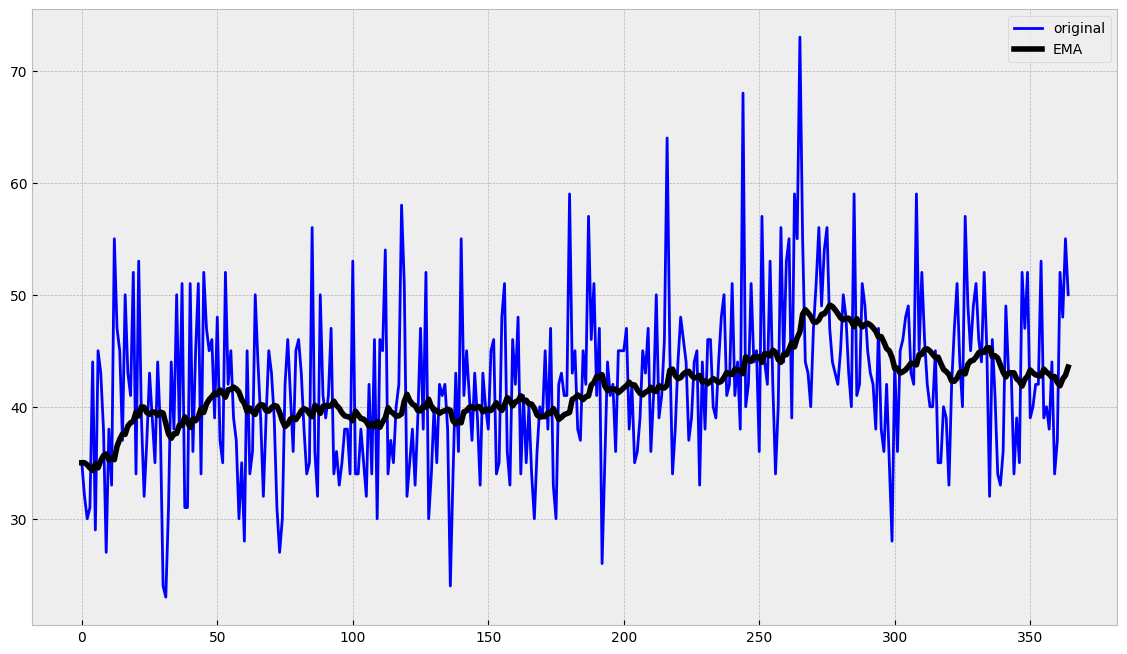

In [38]:
ema = exponential_moving_average(all_series["Daily total female births in California"], 0.06)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Daily total female births in California"], color='blue',label='original')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

### Функция, которая предсказывает наблюдения ряда на основе ema.

In [35]:
def forecast_ema_constant(series, alpha, n_pred):
    smoothed_train_series = exponential_moving_average(series, alpha)
    last_smoothed_value = smoothed_train_series.iloc[-1]
    predictions = pd.Series([last_smoothed_value] * n_pred)
    return predictions

def mse_ema_optimized(X):
    alpha = X[0]

    predictions = forecast_ema_constant(train, alpha, len(test))
    error = mean_squared_error(predictions, test)
    return error

In [36]:
opt = minimize(mse_ema_optimized, x0=[0.5],  method="L-BFGS-B", bounds=((0, 1),))

In [37]:
n_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 35.52888888888893
        x: [ 6.329e-02]
      nit: 5
      jac: [-7.105e-07]
     nfev: 26
     njev: 13
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


# Двойное экспоненциальное сглаживание DEMA на нестационарном

$$\hat{y}_t=l_t + s_t$$

$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$

$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$

До сих пор мы рассматривали ряд - как единую составляющую. Но на самом деле, ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [58]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [59]:
def plot_dema(alpha, beta):
    dema = double_ema(all_series["Daily total female births in California"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(all_series["Daily total female births in California"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

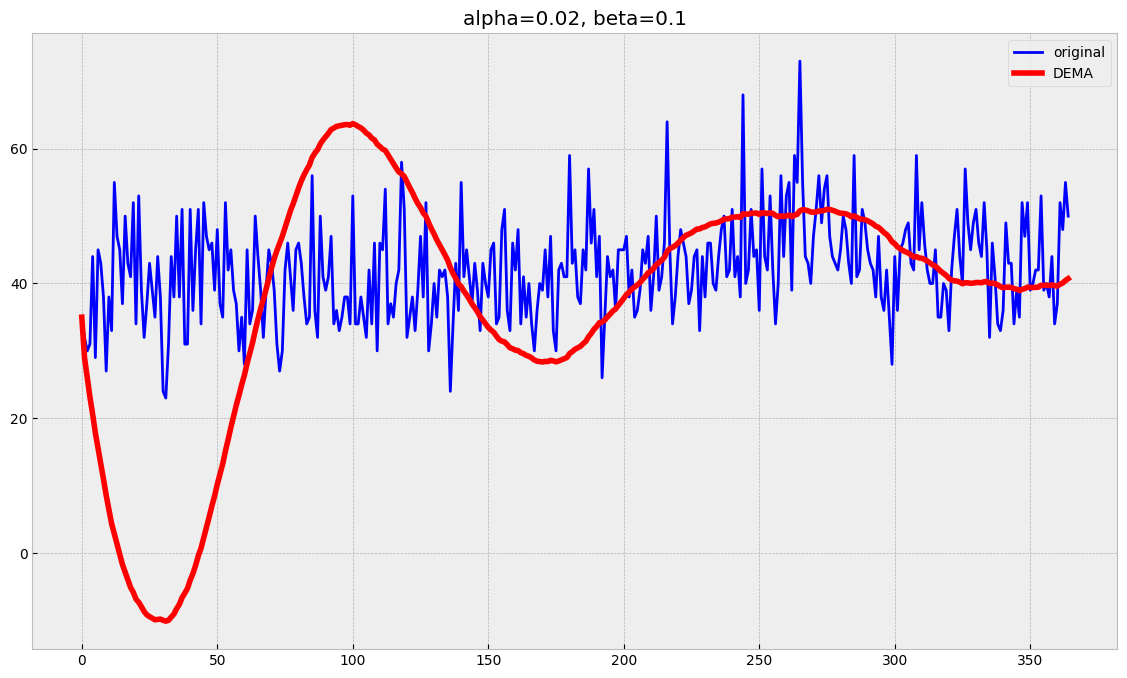

In [64]:
plot_dema(0.02, 0.1)

Настройка параметров $\alpha$ и $\beta$ может порой давать самые причудливые результаты. $\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

### Функция, которая предсказывает наблюдения ряда на основе double_ema.

In [39]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(preds)

In [42]:
def mse_dema_optimized(X):
    alpha, beta = X

    predictions = double_ema_with_preds(train, alpha, beta, len(test))
    error = mean_squared_error(predictions, test)
    return error

In [62]:
opt = minimize(mse_dema_optimized, x0=[0.2,0.1], method='Powell', bounds = ((0, 1), (0, 1)))

In [63]:
n_opt = opt.x
print(opt)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 43.12976733826499
       x: [ 2.249e-02  1.497e-01]
     nit: 3
   direc: [[ 0.000e+00  1.000e+00]
           [-2.987e-03  9.203e-03]]
    nfev: 104


# TEMA на нестанционарном

In [65]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [66]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [67]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [75]:
def plot_tema(alpha, beta, gamma, ser=all_series["Daily total female births in California"], ser_to_plot=all_series["Daily total female births in California"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

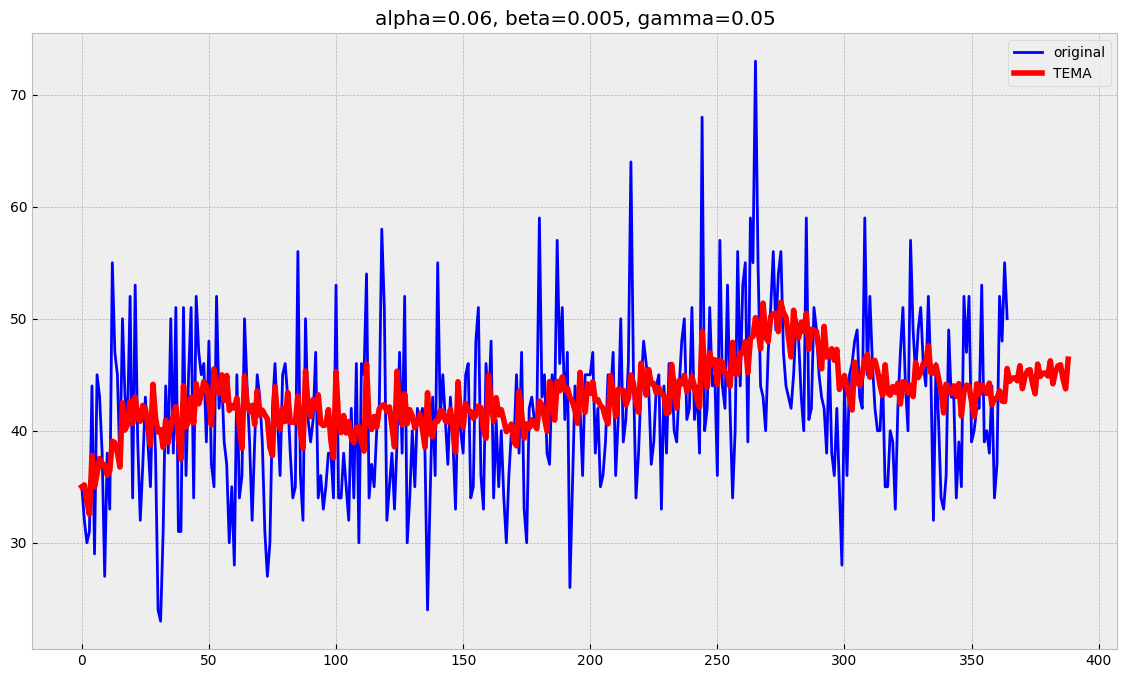

In [87]:
plot_tema(0.06, 0.005, 0.05)

In [70]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [85]:
opt = minimize(mse, x0=[0.1,0.2,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [86]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 41.88748977202363
        x: [ 6.355e-02  5.980e-03  5.046e-02]
      nit: 19
      jac: [-3.175e-03 -1.350e-02 -2.117e-03]
     nfev: 128
     njev: 32
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


# Скользящее среднее MA на стационарном

In [88]:
from scipy.stats import boxcox

In [89]:
transformed_births_series = boxcox(all_series["Daily total female births in California"], 0)

In [90]:
differenced_births_series = np.diff(transformed_births_series, 1)

In [106]:
series_ns = pd.Series(differenced_births_series)

In [107]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

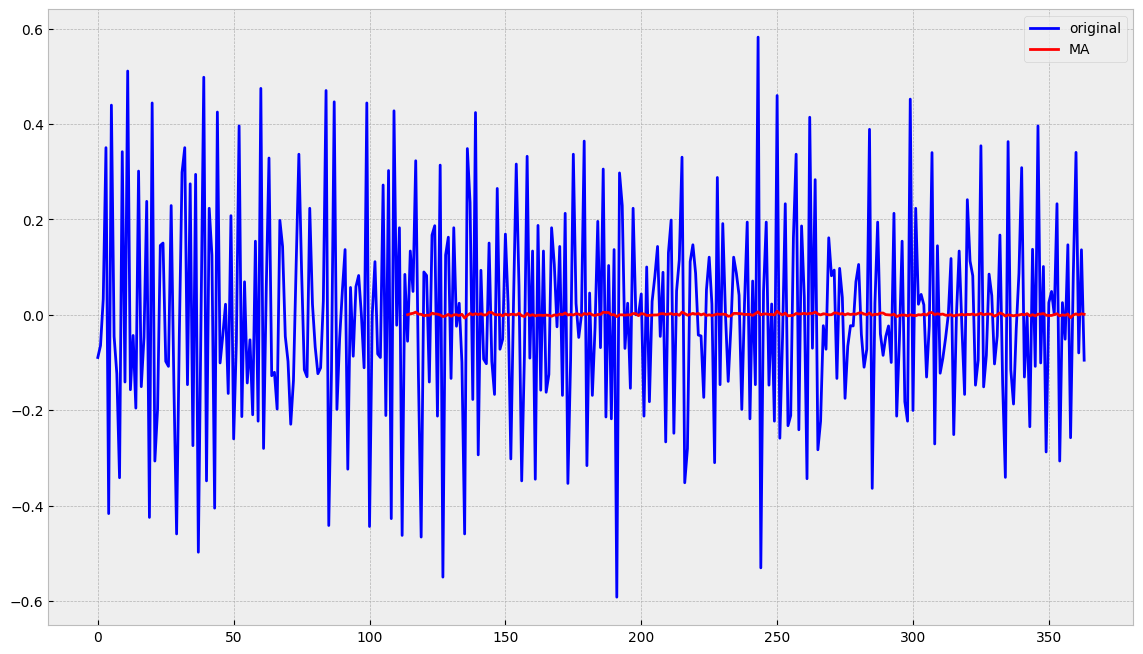

In [114]:

ma = moving_average(series_ns, 115)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_ns, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

Такая вариация moving average позволяет учитывать временной контекст. Чем раньше было событие - тем меньше оно влияет на прогнозируемое событие


In [109]:
train, test, val = series_ns[:300], series_ns[300:330], series_ns[330:]

In [110]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        next_val = new_series[-N:].mean()
        next_val_series = pd.Series([next_val])
        new_series = pd.concat([new_series, next_val_series], ignore_index=True)
    return pd.Series(new_series)

In [111]:
def mse(X):
    n = int(X[0])
    result = predict(train, n, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [112]:
opt = minimize(mse, x0=[16], method='Powell', bounds=((1, len(train)),))

In [113]:
n_opt = opt.x
print(opt)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.024608186670674086
       x: [ 1.152e+02]
     nit: 2
   direc: [[ 6.083e-03]]
    nfev: 89


# Экспоненциальное сглаживание EMA на стационарном

In [116]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

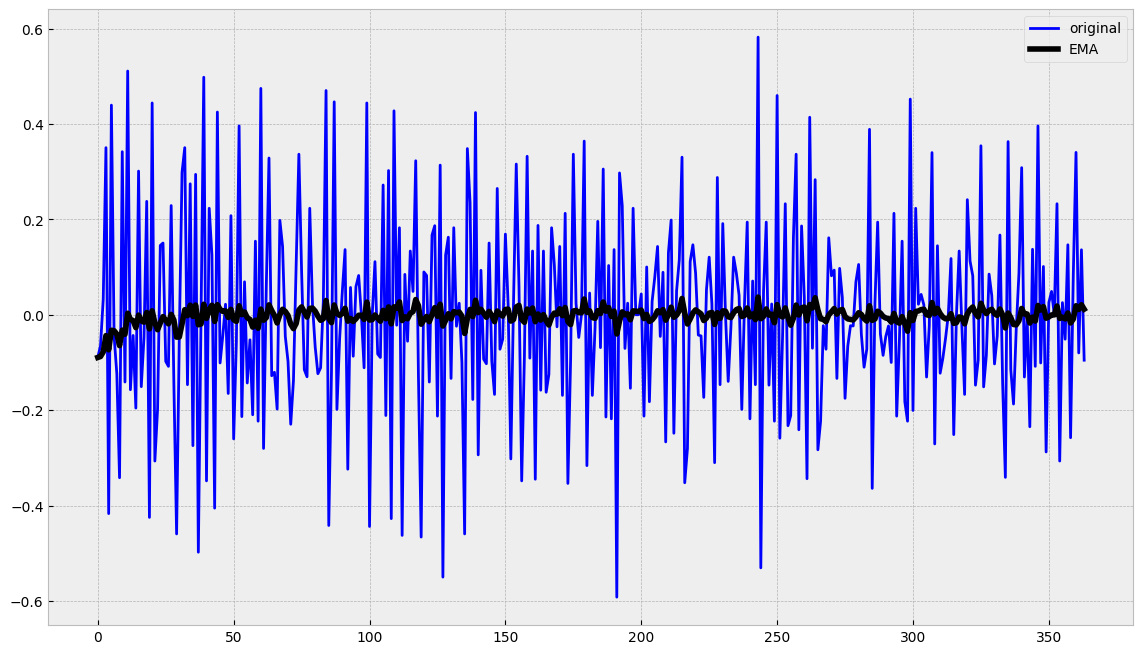

In [121]:
ema = exponential_moving_average(series_ns, 0.08)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_ns, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

### Функция, которая предсказывает наблюдения ряда на основе ema.

In [118]:
def forecast_ema_constant(series, alpha, n_pred):
    smoothed_train_series = exponential_moving_average(series, alpha)
    last_smoothed_value = smoothed_train_series.iloc[-1]
    predictions = pd.Series([last_smoothed_value] * n_pred)
    return predictions

def mse_ema_optimized(X):
    alpha = X[0]

    predictions = forecast_ema_constant(train, alpha, len(test))
    error = mean_squared_error(predictions, test)
    return error

In [152]:
opt = minimize(mse_ema_optimized, x0=[0.1],  method="L-BFGS-B", bounds=((0, 1),))

In [153]:
n_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.024711003944158687
        x: [ 8.408e-02]
      nit: 4
      jac: [ 1.364e-06]
     nfev: 10
     njev: 5
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


# Двойное экспоненциальное сглаживание DEMA на стационарном

$$\hat{y}_t=l_t + s_t$$

$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$

$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$

До сих пор мы рассматривали ряд - как единую составляющую. Но на самом деле, ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [123]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [124]:
def plot_dema(alpha, beta):
    dema = double_ema(series_ns, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series_ns, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

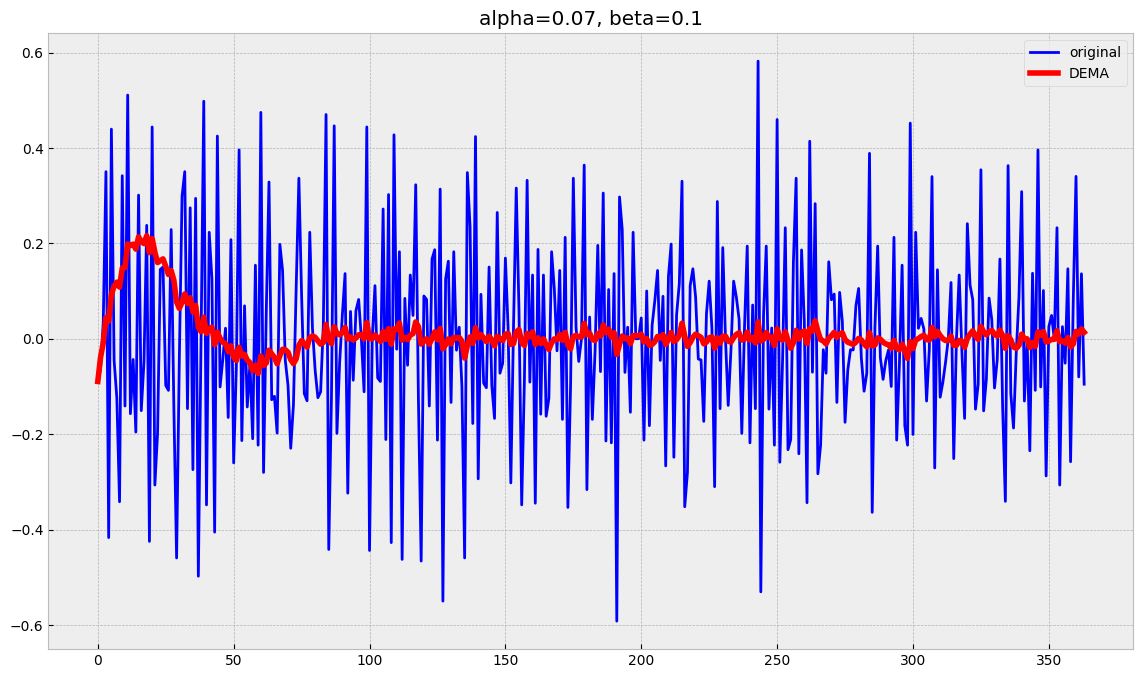

In [130]:
plot_dema(0.07, 0.1)

Настройка параметров $\alpha$ и $\beta$ может порой давать самые причудливые результаты. $\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

### Функция, которая предсказывает наблюдения ряда на основе double_ema.

In [126]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(preds)

In [127]:
def mse_dema_optimized(X):
    alpha, beta = X

    predictions = double_ema_with_preds(train, alpha, beta, len(test))
    error = mean_squared_error(predictions, test)
    return error

In [150]:
opt = minimize(mse_dema_optimized, x0=[0.7,0.7], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [151]:
n_opt = opt.x
print(opt)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.02463741897489229
        x: [ 6.174e-02  1.459e-01]
      nit: 12
      jac: [-3.199e-05 -3.667e-05]
     nfev: 45
     njev: 15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


# TEMA на станционарном

In [131]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [132]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [133]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [135]:
def plot_tema(alpha, beta, gamma, ser=series_ns, ser_to_plot=series_ns, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

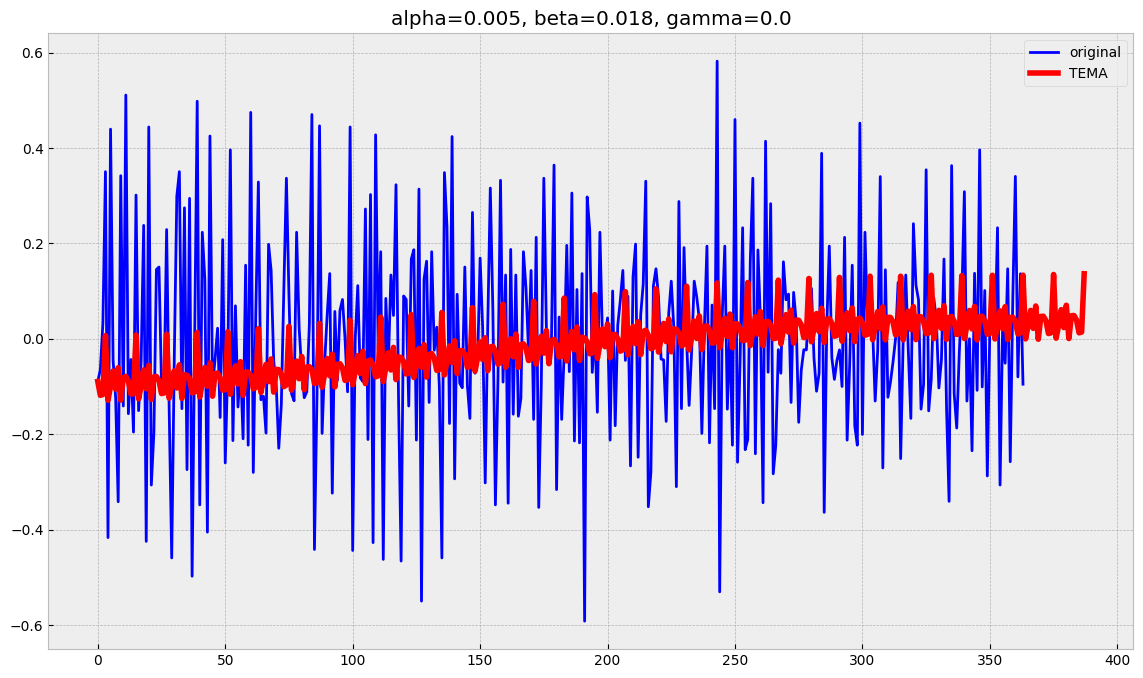

In [140]:
plot_tema(0.005, 0.018, 0.0)

In [137]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [160]:
opt = minimize(mse, x0=[0.5,0.5,0.5], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [161]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.031644846635411256
        x: [ 7.085e-02  1.171e-01  8.641e-02]
      nit: 30
      jac: [-6.148e-07 -1.381e-07 -4.996e-07]
     nfev: 148
     njev: 37
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


# Выбор оптимальной модели

Самое низкое значение MSE для нестационарного ряда удалось получить в модели MA = 35.20596991749929

Самое низкое значение MSE для стационарного ряда удалось получить в модели MA = 0.024608186670674086